In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [13]:
# Use for conda env:tfkGPU - otherwise comment out
import tensorflow as tf
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

In [14]:
train_df = pd.read_csv('../../data/cleaned_study_data/sub1_train.csv', index_col= 'Unnamed: 0')
test_df = pd.read_csv('../../data/cleaned_study_data/sub1_test.csv', index_col= 'Unnamed: 0')

In [15]:
train_df.head()

time  Power    Oxygen  Cadence    HR    RF
0     3    0.0  602.0000      0.0  86.0  16.0
1     4    0.0  578.1250      0.0  86.0  16.0
2     5    0.0  558.7500      0.0  86.0  16.0
3     6    0.0  542.1875      0.0  86.0  16.0
4     7    0.0  527.5000      0.0  86.0  16.0

In [16]:
test_df.head()

time  Power      Oxygen  Cadence         HR         RF
0     2    0.0  454.500000      0.0  69.600000  26.300000
1     3    0.0  501.583333      0.0  69.500000  25.083333
2     4    0.0  524.261905      0.0  69.523810  24.166667
3     5    0.0  531.687500      0.0  69.625000  23.437500
4     6    0.0  528.944444      0.0  69.777778  22.833333

In [18]:
# Scaling the data
mm_scaler = MinMaxScaler()
train_data_scaled = mm_scaler.fit_transform(train_df)
test_data_scaled = mm_scaler.fit_transform(test_df)

In [19]:
pd.DataFrame(train_data_scaled)

0    1         2    3         4         5
0     0.000706  0.0  0.107346  0.0  0.116954  0.092302
1     0.001059  0.0  0.102187  0.0  0.116954  0.092302
2     0.001412  0.0  0.098000  0.0  0.116954  0.092302
3     0.001766  0.0  0.094420  0.0  0.116954  0.092302
4     0.002119  0.0  0.091246  0.0  0.116954  0.092302
...        ...  ...       ...  ...       ...       ...
6396  0.993644  0.0  0.113246  0.0  0.291420  0.220027
6397  0.993997  0.0  0.112509  0.0  0.289848  0.220973
6398  0.994350  0.0  0.108670  0.0  0.287883  0.228542
6399  0.994703  0.0  0.106153  0.0  0.286582  0.235030
6400  0.995056  0.0  0.105617  0.0  0.286276  0.239896

[6401 rows x 6 columns]

In [31]:
# X = data_scaled
# y = data_scaled[:,3] # HR is the target

In [20]:
# Train/Test Split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, shuffle= False, random_state = 42)
X_train = train_data_scaled
X_test = test_data_scaled
y_train = train_data_scaled[:,4]
y_test = test_data_scaled[:,4]


In [26]:
X_train.shape

(6401, 6)

In [22]:
X_test.shape

(2579, 6)

In [23]:
y_train.shape

(6401,)

In [24]:
y_test.shape

(2579,)

In [27]:
win_length = 60
batch_size= 32
num_features = X_train.shape[1]

# Create training sequences
train_generator = TimeseriesGenerator(X_train, y_train, length= win_length, sampling_rate= 1, batch_size= batch_size )

# Create test sequences
test_generator = TimeseriesGenerator(X_test, y_test, length= win_length, sampling_rate= 1, batch_size= batch_size )

In [28]:
train_generator[0][0].shape

(32, 60, 6)

In [29]:
# LSTM Model
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha= 0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences= False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           69120     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 60, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 128)           131584    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 60, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',
                                                 patience= 5,
                                                 mode= 'min')

model.compile(loss= tf.losses.MeanSquaredError(),
              optimizer= tf.optimizers.Adam()
              #metrics= [tf.metrics.MeanAbsoluteError()]
             )

history = model.fit(train_generator, epochs= 500,
                              validation_data= test_generator,
                              shuffle= False
                              #callbacks= [early_stopping]
                             )

Epoch 1/500
199/199 [==============================] - 5s 27ms/step - loss: 0.0172 - val_loss: 0.0405
Epoch 2/500
199/199 [==============================] - 5s 24ms/step - loss: 0.0296 - val_loss: 0.0377
Epoch 3/500
199/199 [==============================] - 5s 24ms/step - loss: 0.0156 - val_loss: 0.1815
Epoch 4/500
199/199 [==============================] - 5s 24ms/step - loss: 0.0121 - val_loss: 0.1090
Epoch 5/500
199/199 [==============================] - 5s 25ms/step - loss: 0.0102 - val_loss: 0.0554
Epoch 6/500
199/199 [==============================] - 5s 24ms/step - loss: 0.0074 - val_loss: 0.0548
Epoch 7/500
199/199 [==============================] - 5s 25ms/step - loss: 0.0085 - val_loss: 0.0543
Epoch 8/500
199/199 [==============================] - 5s 25ms/step - loss: 0.0061 - val_loss: 0.0369
Epoch 9/500
199/199 [==============================] - 5s 24ms/step - loss: 0.0050 - val_loss: 0.0382
Epoch 10/500
199/199 [==============================] - 5s 24ms/step - loss: 0.005

In [32]:
train_preds = model.predict(train_generator)
test_preds = model.predict(test_generator)

In [33]:
r2_score(y_train[win_length:], train_preds), r2_score(y_test[win_length:], test_preds)

(0.9745727939464826, 0.9653411137260387)

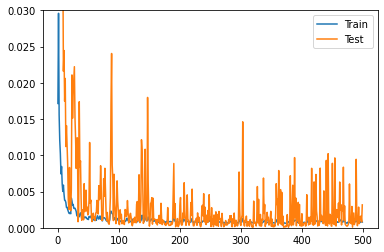

In [36]:
plt.plot(history.history['loss'], label= 'Train')
plt.plot(history.history['val_loss'], label= 'Test')
plt.legend()
plt.ylim(0, .03);

In [37]:
hr_test_results_sc = pd.DataFrame(X_test[win_length:])

In [38]:
hr_test_results_sc[4] = test_preds

In [39]:
hr_test_results_sc.head(10)

0    1         2    3         4         5
0  0.023274  0.0  0.100425  0.0  0.033074  0.136786
1  0.023662  0.0  0.108897  0.0  0.033215  0.116866
2  0.024050  0.0  0.114402  0.0  0.033772  0.092961
3  0.024438  0.0  0.114357  0.0  0.034574  0.075697
4  0.024825  0.0  0.108761  0.0  0.036578  0.065073
5  0.025213  0.0  0.103106  0.0  0.039295  0.061089
6  0.025601  0.0  0.099122  0.0  0.042279  0.060558
7  0.025989  0.0  0.096810  0.0  0.044606  0.063479
8  0.026377  0.0  0.096169  0.0  0.046185  0.069854
9  0.026765  0.0  0.095182  0.0  0.047027  0.082780

In [40]:
# Column '4' is y_test predictions, de-scaled
hr_test_results = pd.DataFrame(mm_scaler.inverse_transform(hr_test_results_sc))
hr_test_results.head(10)

0    1           2    3          4          5
0  62.0  0.0  491.400000  0.0  67.877409  17.400000
1  63.0  0.0  521.025000  0.0  67.889701  16.650000
2  64.0  0.0  540.275000  0.0  67.938202  15.750000
3  65.0  0.0  540.116667  0.0  68.007974  15.100000
4  66.0  0.0  520.550000  0.0  68.182322  14.700000
5  67.0  0.0  500.775000  0.0  68.418687  14.550000
6  68.0  0.0  486.845000  0.0  68.678263  14.530000
7  69.0  0.0  478.760000  0.0  68.880764  14.640000
8  70.0  0.0  476.520000  0.0  69.018083  14.880000
9  71.0  0.0  473.066667  0.0  69.091315  15.366667

In [56]:
# This is y_test, de-scaled (Original)
pd.DataFrame(test_df['HR'][win_length:]).reset_index().drop('index', axis= 1)

HR
0     68.200000
1     68.225000
2     68.275000
3     68.416667
4     68.650000
...         ...
2514  80.250000
2515  80.500000
2516  80.718750
2517  80.892857
2518  81.000000

[2519 rows x 1 columns]

In [ ]:
pd.DataFrame(test_df['Power'][win_length:]).reset_index().drop('index', axis= 1) * .5

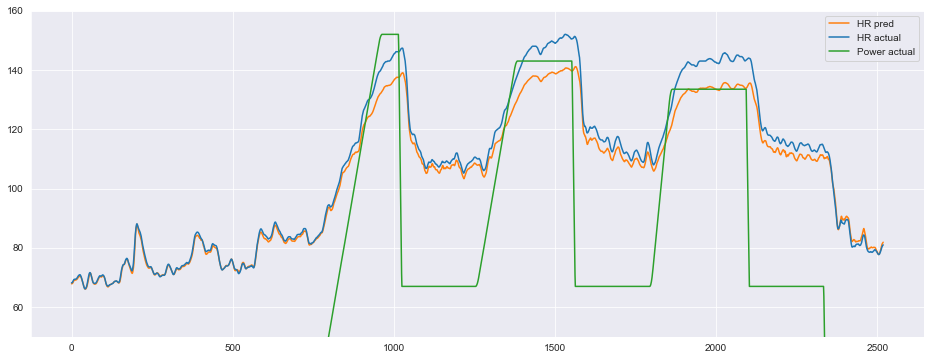

In [65]:
sns.set_style('darkgrid')

plt.figure(figsize= (16, 6))
plt.plot(hr_test_results[4], color = 'tab:orange', label= 'HR pred')
plt.plot(pd.DataFrame(test_df['HR'][win_length:]).reset_index().drop('index', axis= 1), color= 'tab:blue', label= 'HR actual')
plt.plot(pd.DataFrame(test_df['Power'][win_length:]).reset_index().drop('index', axis= 1) * .5, color= 'tab:green', label= 'Power actual')
plt.ylim(50, 160)
plt.legend();